## **Assignment 3: Pong**    
### **Reinforcement Learning Programming - CSCN 8020**            

**Name:**  Mandeep Singh Brar           
**ID Number:**  8989367     

Train a Deep Q-Network (DQN) agent to play **PongDeterministic-v4** using stacked grayscale frames as input. You’ll implement a CNN-based Q-network with a target network and experience replay, apply the required ε-greedy exploration schedule, and run three experiments: the default setting, a mini-batch sweep (8→16), and a target-update sweep (10→3). For each, you’ll log Score per episode and Average reward of the last 5 episodes (Avg5) against Total Steps, save plots/CSVs, and finish with a comparison and best-setting recommendation.

---

#### **Importing Libraries**

Load core libraries (NumPy, PyTorch, Gym) and plotting utilities, plus the provided preprocessing helper.

In [12]:
# Core & typing
import os, random, time
from collections import deque, namedtuple
from typing import Tuple, Dict, Any

# Numerics, plots, tables
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# RL / Deep Learning
import gym
import torch
import torch.nn as nn
import torch.optim as optim

# Helper from assignment (crop→84x80, grayscale; returns (1,H,W,1))
from assignment3_utils import process_frame


These imports power environment interaction, neural network training, metrics logging, and figure generation. The helper process_frame converts raw frames to 84×80 grayscale.

---

#### **Configuration & Hyperparameters**

Define environment ID, image shape, frame-stack size, and assignment-specified hyperparameters.

In [13]:
# Env & state
ENV_ID = "PongDeterministic-v4"   # exact id
IMAGE_SHAPE = (84, 80)            # when using crop helper
FRAME_STACK  = 4                  # 4 frames (no blending)

# DQN (per assignment)
GAMMA = 0.95
EPS_INIT, EPS_DECAY, EPS_MIN = 1.0, 0.995, 0.05  # ε ← ε*0.995 until 0.05
BATCH_DEFAULT         = 8
TARGET_UPDATE_DEFAULT = 10

# System & I/O
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
OUTDIR = "results_pong_dqn"; os.makedirs(OUTDIR, exist_ok=True)

def set_seed(seed: int = 42):
    random.seed(seed); np.random.seed(seed)
    torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)

set_seed(42)
print("Device:", DEVICE)


Device: cpu


We set PongDeterministic-v4, state shape (4, 84, 80), γ=0.95, ε schedule (ε₀=1.0, δ=0.995, ε_min=0.05; episode-wise decay), default batch size 8, and target update every 10 episodes.

---

#### **Preprocessing & 4-Frame Stacker**

Convert raw RGB frames to grayscale 84×80 and stack the latest 4 frames (no blending).

In [14]:
class FrameStacker:
    """Keeps last N preprocessed frames. Output: (C,H,W) = (4,84,80)."""
    def __init__(self, image_shape: Tuple[int,int], stack: int = FRAME_STACK):
        self.h, self.w = image_shape; self.stack = stack
        self.frames = deque(maxlen=stack)
    def reset(self): self.frames.clear()
    def push(self, frame_1HW1: np.ndarray):
        self.frames.append(np.squeeze(frame_1HW1, axis=(0,3)).astype(np.float32))  # (H,W)
    def state(self) -> np.ndarray:
        pad = [np.zeros((self.h,self.w), np.float32)]*(self.stack - len(self.frames))
        return np.stack(pad + list(self.frames), axis=0).astype(np.float32)        # (4,84,80)

def preprocess(obs: np.ndarray) -> np.ndarray:
    return process_frame(obs, IMAGE_SHAPE)

def safe_fire(env):
    """Send FIRE(1) once if needed; return (obs, done). Handles old/new Gym API."""
    try:
        step = env.step(1)
        if len(step)==5: return step[0], (step[2] or step[3])
        else:            return step[0], step[2]
    except Exception:
        return None, False


Stacking exposes short-term dynamics (ball/paddle motion) while reducing input size for the CNN. Output is channels-first (4, 84, 80) to match PyTorch.

---

#### **DQN Network (CNN)**

Build the convolutional Q-network that maps stacked frames to action Q-values.

In [15]:
class DQNCNN(nn.Module):
    """Input: (B,4,84,80) → Output: Q-values for each action."""
    def __init__(self, action_dim: int):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(4, 32, 8, 4), nn.ReLU(True),   # -> (32,20,19)
            nn.Conv2d(32,64, 4, 2), nn.ReLU(True),   # -> (64, 9, 8)
            nn.Conv2d(64,64, 3, 1), nn.ReLU(True),   # -> (64, 7, 6)
        )
        self.head = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64*7*6, 512), nn.ReLU(True),
            nn.Linear(512, action_dim)
        )
    def forward(self, x): return self.head(self.features(x))


Architecture:  
     
Conv(4→32, k8 s4) → ReLU → Conv(32→64, k4 s2) → ReLU → Conv(64→64, k3 s1) → ReLU → Flatten → Dense(512) → ReLU → Dense(|A|=6). 

Trained with Huber loss and Adam, with gradient clipping for stability.

---

#### **Replay Buffer, Epsilon Scheduler, Policy, Loss**

Implement experience replay, ε-greedy action selection, and the DQN target loss.

In [16]:
Transition = namedtuple("Transition", ("state","action","reward","next_state","done"))

class ReplayBuffer:
    def __init__(self, capacity: int = 100_000): self.buf = deque(maxlen=capacity)
    def push(self, *args): self.buf.append(Transition(*args))
    def sample(self, batch_size: int):
        b = random.sample(self.buf, batch_size)
        S  = torch.tensor(np.stack([t.state      for t in b]), dtype=torch.float32, device=DEVICE)
        A  = torch.tensor([t.action    for t in b], dtype=torch.long,   device=DEVICE).unsqueeze(1)
        R  = torch.tensor([t.reward    for t in b], dtype=torch.float32, device=DEVICE).unsqueeze(1)
        S2 = torch.tensor(np.stack([t.next_state for t in b]), dtype=torch.float32, device=DEVICE)
        D  = torch.tensor([t.done      for t in b], dtype=torch.float32,  device=DEVICE).unsqueeze(1)
        return S,A,R,S2,D
    def __len__(self): return len(self.buf)

class EpsilonScheduler:
    """EPISODE-WISE: call .step() ONCE per episode."""
    def __init__(self, eps_init=EPS_INIT, eps_min=EPS_MIN, eps_decay=EPS_DECAY):
        self.eps, self.eps_min, self.decay = eps_init, eps_min, eps_decay
    def value(self): return self.eps
    def step(self): self.eps = self.eps*self.decay if self.eps >= self.eps_min else self.eps_min

def select_action(qnet, state_np, eps, action_dim):
    if random.random() < eps: return random.randrange(action_dim)
    with torch.no_grad():
        s = torch.tensor(state_np[None,...], dtype=torch.float32, device=DEVICE)
        return int(qnet(s).argmax(1).item())

def dqn_loss(qnet, tgt, batch, gamma=GAMMA):
    S,A,R,S2,D = batch
    q_sa = qnet(S).gather(1, A)
    with torch.no_grad():
        max_q_s2 = tgt(S2).max(1, keepdim=True)[0]
        y = R + gamma*(1.0 - D)*max_q_s2
    return nn.SmoothL1Loss()(q_sa, y)  # Huber


The replay buffer decorrelates samples; ε-greedy trades exploration/exploitation; the target network provides stable bootstrapped targets 
𝑟
+
𝛾
⋅
𝑚
𝑎
𝑥
_
𝑎
′
𝑄
_
𝑡
𝑎
𝑟
𝑔
𝑒
𝑡
(
𝑠
′
,
𝑎
′
)
 with SmoothL1 (Huber) loss.

 ---

#### **Episode Loop (Environment Rollout)**

Run one episode: reset, optional FIRE start, step using ε-greedy, store transitions, and train when the buffer is warmed up

In [17]:
def make_env(): return gym.make(ENV_ID)

def run_episode(env, q, tgt, buf, opt, eps, batch_size=BATCH_DEFAULT, gamma=GAMMA, train=True):
    # Reset & FIRE if needed
    rs = env.reset(); obs = rs[0] if isinstance(rs, tuple) else rs
    try:
        obs, _ = safe_fire(env)
        if obs is None: rs = env.reset(); obs = rs[0] if isinstance(rs, tuple) else rs
    except Exception: pass

    # Build initial state (repeat first frame 4x)
    fs = FrameStacker(IMAGE_SHAPE, FRAME_STACK); fs.reset()
    f0 = preprocess(obs); [fs.push(f0) for _ in range(FRAME_STACK)]
    state = fs.state()

    total_r, steps, done = 0.0, 0, False
    A = env.action_space.n

    while not done:
        a = select_action(q, state, eps.value() if train else 0.05, A)
        out = env.step(a)
        if len(out)==5: nxt,r,term,trunc,_ = out; done = term or trunc
        else:           nxt,r,done,_ = out

        total_r += r; steps += 1
        fs.push(preprocess(nxt)); next_state = fs.state()
        buf.push(state, a, float(r), next_state, float(done))
        state = next_state

        if train and len(buf) >= max(batch_size, 1000):
            batch = buf.sample(batch_size)
            loss = dqn_loss(q, tgt, batch, gamma)
            opt.zero_grad(set_to_none=True); loss.backward()
            nn.utils.clip_grad_norm_(q.parameters(), 10.0)
            opt.step()

        # NOTE: epsilon decay happens once per episode (not here)
    return total_r, steps


Each step: preprocess next frame, update the stacked state, push transition to replay, sample minibatches (after warm-up), backpropagate loss, and accumulate episode reward & step counts.

---

#### **Single-Experiment Trainer (Console Output)**

Train for N episodes with specified batch size and target-update rate; print per-episode lines.

In [18]:
import time

def train_dqn_experiment(
    episodes: int,
    batch_size: int,
    target_every: int,
    gamma: float = GAMMA,
    lr: float = 1e-4,
    seed: int = 42,
) -> Dict[str, Any]:
    """
    Runs ONE experiment with the requested batch size and target-update rate.
    Prints:
      Starting training with Batch Size: X and Target Update: Y episodes
      Episode: i/N | Steps: <cumulative> | Score: r | Avg (5): ... | Epsilon: ... | Time: ...s
    Returns logs including per-episode and cumulative steps.
    """
    print(f"Starting training with Batch Size: {batch_size} and Target Update: {target_every} episodes")

    # ---- setup (same as train_dqn) ----
    set_seed(seed)
    env = make_env()
    action_dim = env.action_space.n

    q_net  = DQNCNN(action_dim).to(DEVICE)
    tgt_net = DQNCNN(action_dim).to(DEVICE)
    tgt_net.load_state_dict(q_net.state_dict())

    optimizer = optim.Adam(q_net.parameters(), lr=lr)
    buffer = ReplayBuffer(100_000)
    eps_sched = EpsilonScheduler(EPS_INIT, EPS_MIN, EPS_DECAY)

    ep_rewards, ep_steps, ep_cum_steps, ep_times, avg5 = [], [], [], [], []
    cum_steps = 0

    for ep in range(1, episodes + 1):
        t0 = time.time()

        R, S = run_episode(
            env, q_net, tgt_net, buffer, optimizer, eps_sched,
            batch_size=batch_size, gamma=gamma, train=True
        )
        dt = time.time() - t0

        # logs
        cum_steps += S
        ep_rewards.append(R)
        ep_steps.append(S)
        ep_cum_steps.append(cum_steps)
        ep_times.append(dt)
        avg5.append(float(np.mean(ep_rewards[-5:])))

        # target sync by episodes
        if ep % target_every == 0:
            tgt_net.load_state_dict(q_net.state_dict())

        print(
            f"Episode: {ep}/{episodes} | "
            f"Steps: {cum_steps} | "
            f"Score: {R:.1f} | "
            f"Avg (5): {avg5[-1]:.2f} | "
            f"Epsilon: {eps_sched.value():.4f} | "
            f"Time: {dt:.2f}s"
        )

    env.close()
    return {
        "ep_rewards": ep_rewards,
        "ep_steps": ep_steps,
        "ep_cum_steps": ep_cum_steps,   # cumulative steps (printed)
        "ep_times": ep_times,
        "avg5": avg5,
        "batch_size": batch_size,
        "target_every": target_every,
    }


After each episode, decay ε once (per assignment), sync the target every K episodes, and print:
Episode: i/N | Steps: <cumulative> | Score: r | Avg (5): a | Epsilon: e | Time: t s.

---

#### **Helpers: Results Table, CSV, and Plots**

Build a tidy DataFrame, save a CSV, and generate plots vs Total Steps.

In [19]:
def train_dqn_experiment(
    episodes: int,
    batch_size: int,
    target_every: int,
    gamma: float = GAMMA,
    lr: float = 1e-4,
    seed: int = 42,
) -> Dict[str, Any]:
    print(f"Starting training with Batch Size: {batch_size} and Target Update: {target_every} episodes")

    # setup
    set_seed(seed)
    env = make_env()
    A = env.action_space.n
    q, tgt = DQNCNN(A).to(DEVICE), DQNCNN(A).to(DEVICE); tgt.load_state_dict(q.state_dict())
    opt = optim.Adam(q.parameters(), lr=lr)
    buf = ReplayBuffer(100_000); eps = EpsilonScheduler(EPS_INIT, EPS_MIN, EPS_DECAY)

    ep_rewards, ep_steps, ep_cum_steps, ep_times, avg5 = [], [], [], [], []
    cum_steps = 0

    for ep in range(1, episodes + 1):
        t0 = time.time()
        R, S = run_episode(env, q, tgt, buf, opt, eps, batch_size=batch_size, gamma=gamma, train=True)
        dt = time.time() - t0

        # EPISODE-wise epsilon decay
        eps.step()

        cum_steps += S
        ep_rewards.append(R); ep_steps.append(S); ep_cum_steps.append(cum_steps); ep_times.append(dt)
        avg5.append(float(np.mean(ep_rewards[-5:])))

        if ep % target_every == 0: tgt.load_state_dict(q.state_dict())

        # EXACT format (with cumulative Steps)
        print(
            f"Episode: {ep}/{episodes} | "
            f"Steps: {cum_steps} | "
            f"Score: {R:.1f} | "
            f"Avg (5): {avg5[-1]:.2f} | "
            f"Epsilon: {eps.value():.4f} | "
            f"Time: {dt:.2f}s"
        )

    env.close()
    return {
        "ep_rewards": ep_rewards,
        "ep_steps": ep_steps,
        "ep_cum_steps": ep_cum_steps,
        "ep_times": ep_times,
        "avg5": avg5,
        "batch_size": batch_size,
        "target_every": target_every,
    }


We persist `reward`, `Avg5`, `per-episode` and `cumulative steps`, and `episode times`. Two plots per run: Score vs Steps and Avg5 vs Steps, matching the assignment’s “with the number of steps” requirement.

---

#### **Results & Plotting (Per-Experiment Summary)**

After each experiment, automatically save artifacts and print a compact summary.

In [20]:
def build_results_df(logs: Dict[str, Any]) -> pd.DataFrame:
    episodes = np.arange(1, len(logs["ep_rewards"]) + 1)
    return pd.DataFrame({
        "episode": episodes,
        "reward": logs["ep_rewards"],
        "steps": logs["ep_steps"],
        "cum_steps": logs["ep_cum_steps"],
        "avg5": logs["avg5"],
        "ep_time_sec": logs["ep_times"]
    })

def save_results_csv(logs: Dict[str, Any], filename: str):
    df = build_results_df(logs)
    path = os.path.join(OUTDIR, filename)
    df.to_csv(path, index=False)
    print(f"[Saved] {path}")

def plot_score_vs_steps(logs: Dict[str, Any], title: str, filename: str):
    x = np.array(logs["ep_cum_steps"])
    y = np.array(logs["ep_rewards"])
    plt.figure(figsize=(10, 4.5))
    plt.plot(x, y, label="Score per Episode")
    plt.xlabel("Total Steps"); plt.ylabel("Score"); plt.title(title); plt.legend()
    plt.tight_layout()
    path = os.path.join(OUTDIR, filename)
    plt.savefig(path, dpi=150); plt.show()
    print(f"[Saved] {path}")

def plot_avg5_vs_steps(logs: Dict[str, Any], title: str, filename: str):
    x = np.array(logs["ep_cum_steps"])
    y = np.array(logs["avg5"])
    plt.figure(figsize=(10, 4.5))
    plt.plot(x, y, label="Avg. Score (Last 5)")
    plt.xlabel("Total Steps"); plt.ylabel("Score"); plt.title(title); plt.legend()
    plt.tight_layout()
    path = os.path.join(OUTDIR, filename)
    plt.savefig(path, dpi=150); plt.show()
    print(f"[Saved] {path}")


In [21]:
def results_and_plotting(logs: Dict[str, Any], title_prefix: str, csv_stub: str):
    print("\n===== Results and Plotting =====")
    save_results_csv(logs, f"{csv_stub}.csv")
    plot_score_vs_steps(logs, f"{title_prefix} — Score per Episode vs. Total Steps",
                        f"{csv_stub}_score_vs_steps.png")
    plot_avg5_vs_steps(logs, f"{title_prefix} — Average 5-Episode Score vs. Total Steps",
                       f"{csv_stub}_avg5_vs_steps.png")
    df = build_results_df(logs)
    last5 = df.tail(5)
    print(f"Episodes: {len(df)} | Final Avg(5): {last5['avg5'].iloc[-1]:.2f} | "
          f"Best Score: {df['reward'].max():.1f} | "
          f"Total Steps: {int(df['cum_steps'].iloc[-1])}")
    print("===== Done =====\n")


Saves CSV + both plots, and prints: episode count, Final Avg(5), Best Score, and Total Steps—ready to paste into the PDF report.        

---

#### **Run the Three Experiments (Separately)**

Execute and log three distinct runs: default, batch sweep, and target-update sweep.

Starting training with Batch Size: 8 and Target Update: 10 episodes
Episode: 1/200 | Steps: 1179 | Score: -19.0 | Avg (5): -19.00 | Epsilon: 0.9950 | Time: 5.29s
Episode: 2/200 | Steps: 2156 | Score: -20.0 | Avg (5): -19.50 | Epsilon: 0.9900 | Time: 24.72s
Episode: 3/200 | Steps: 2975 | Score: -21.0 | Avg (5): -20.00 | Epsilon: 0.9851 | Time: 20.14s
Episode: 4/200 | Steps: 3819 | Score: -21.0 | Avg (5): -20.25 | Epsilon: 0.9801 | Time: 20.43s
Episode: 5/200 | Steps: 4818 | Score: -20.0 | Avg (5): -20.20 | Epsilon: 0.9752 | Time: 24.46s
Episode: 6/200 | Steps: 5980 | Score: -18.0 | Avg (5): -20.00 | Epsilon: 0.9704 | Time: 33.24s
Episode: 7/200 | Steps: 6803 | Score: -21.0 | Avg (5): -20.20 | Epsilon: 0.9655 | Time: 20.10s
Episode: 8/200 | Steps: 7857 | Score: -18.0 | Avg (5): -19.60 | Epsilon: 0.9607 | Time: 28.01s
Episode: 9/200 | Steps: 8956 | Score: -19.0 | Avg (5): -19.20 | Epsilon: 0.9559 | Time: 27.85s
Episode: 10/200 | Steps: 9904 | Score: -20.0 | Avg (5): -19.20 | Epsilon: 0.95

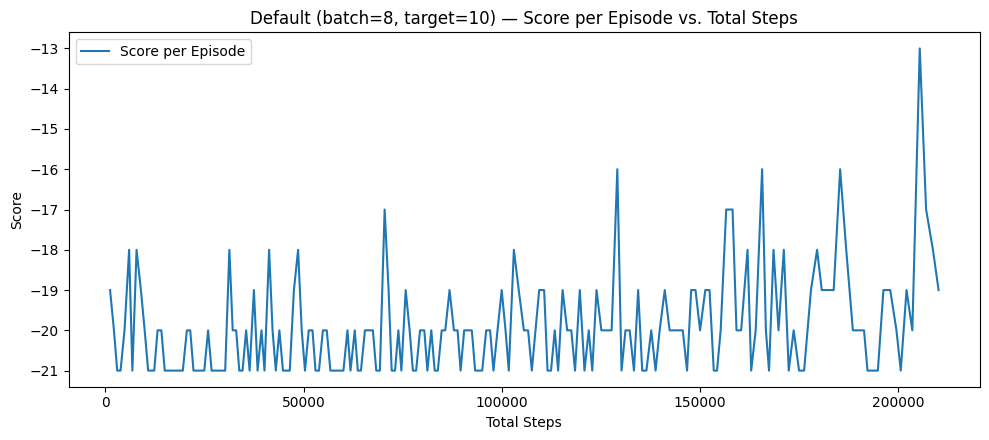

[Saved] results_pong_dqn\exp1_default_score_vs_steps.png


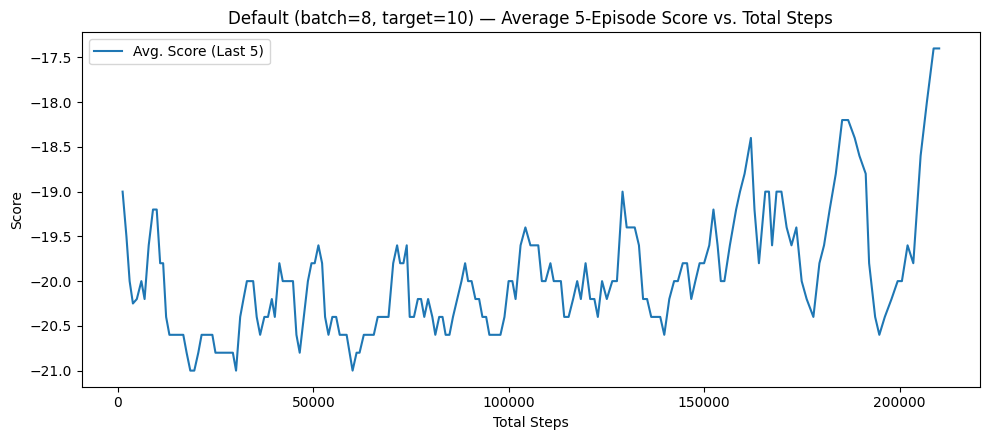

[Saved] results_pong_dqn\exp1_default_avg5_vs_steps.png
Episodes: 200 | Final Avg(5): -17.40 | Best Score: -13.0 | Total Steps: 210108
===== Done =====

Starting training with Batch Size: 16 and Target Update: 10 episodes
Episode: 1/200 | Steps: 1185 | Score: -18.0 | Avg (5): -18.00 | Epsilon: 0.9950 | Time: 7.12s
Episode: 2/200 | Steps: 2278 | Score: -20.0 | Avg (5): -19.00 | Epsilon: 0.9900 | Time: 34.43s
Episode: 3/200 | Steps: 3404 | Score: -20.0 | Avg (5): -19.33 | Epsilon: 0.9851 | Time: 35.34s
Episode: 4/200 | Steps: 4167 | Score: -21.0 | Avg (5): -19.75 | Epsilon: 0.9801 | Time: 27.09s
Episode: 5/200 | Steps: 4958 | Score: -21.0 | Avg (5): -20.00 | Epsilon: 0.9752 | Time: 23.93s
Episode: 6/200 | Steps: 5829 | Score: -21.0 | Avg (5): -20.60 | Epsilon: 0.9704 | Time: 27.18s
Episode: 7/200 | Steps: 6857 | Score: -19.0 | Avg (5): -20.40 | Epsilon: 0.9655 | Time: 31.81s
Episode: 8/200 | Steps: 7639 | Score: -21.0 | Avg (5): -20.60 | Epsilon: 0.9607 | Time: 23.89s
Episode: 9/200 | St

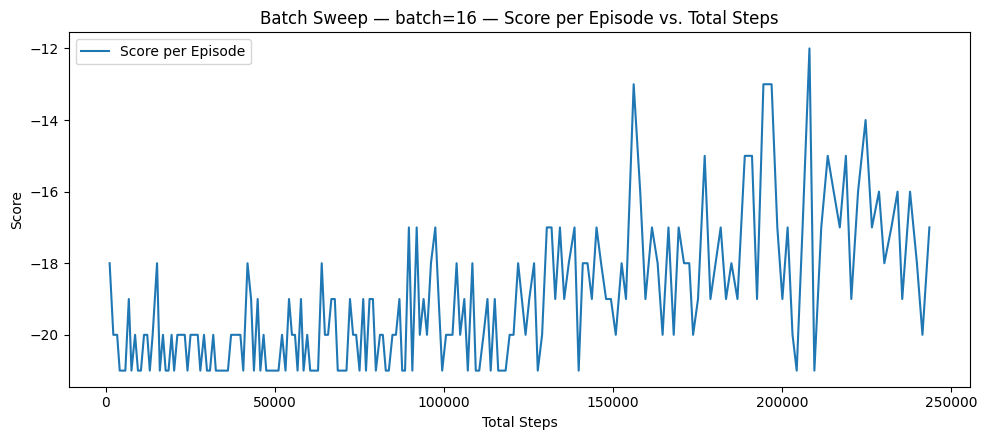

[Saved] results_pong_dqn\exp2_batch16_score_vs_steps.png


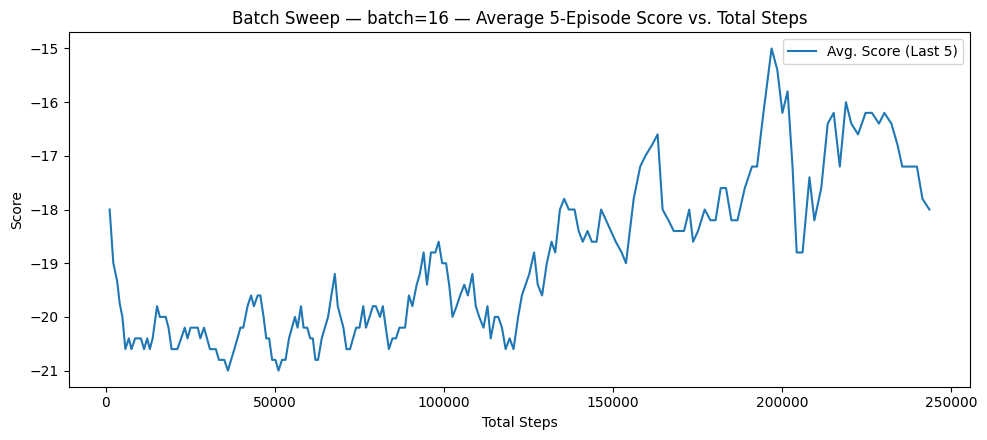

[Saved] results_pong_dqn\exp2_batch16_avg5_vs_steps.png
Episodes: 200 | Final Avg(5): -18.00 | Best Score: -12.0 | Total Steps: 243599
===== Done =====

Starting training with Batch Size: 8 and Target Update: 3 episodes
Episode: 1/200 | Steps: 1179 | Score: -19.0 | Avg (5): -19.00 | Epsilon: 0.9950 | Time: 7.50s
Episode: 2/200 | Steps: 2156 | Score: -20.0 | Avg (5): -19.50 | Epsilon: 0.9900 | Time: 25.02s
Episode: 3/200 | Steps: 2975 | Score: -21.0 | Avg (5): -20.00 | Epsilon: 0.9851 | Time: 18.91s
Episode: 4/200 | Steps: 3819 | Score: -21.0 | Avg (5): -20.25 | Epsilon: 0.9801 | Time: 20.15s
Episode: 5/200 | Steps: 4818 | Score: -20.0 | Avg (5): -20.20 | Epsilon: 0.9752 | Time: 24.61s
Episode: 6/200 | Steps: 5980 | Score: -18.0 | Avg (5): -20.00 | Epsilon: 0.9704 | Time: 26.84s
Episode: 7/200 | Steps: 6803 | Score: -21.0 | Avg (5): -20.20 | Epsilon: 0.9655 | Time: 19.53s
Episode: 8/200 | Steps: 7647 | Score: -21.0 | Avg (5): -20.20 | Epsilon: 0.9607 | Time: 22.93s
Episode: 9/200 | Step

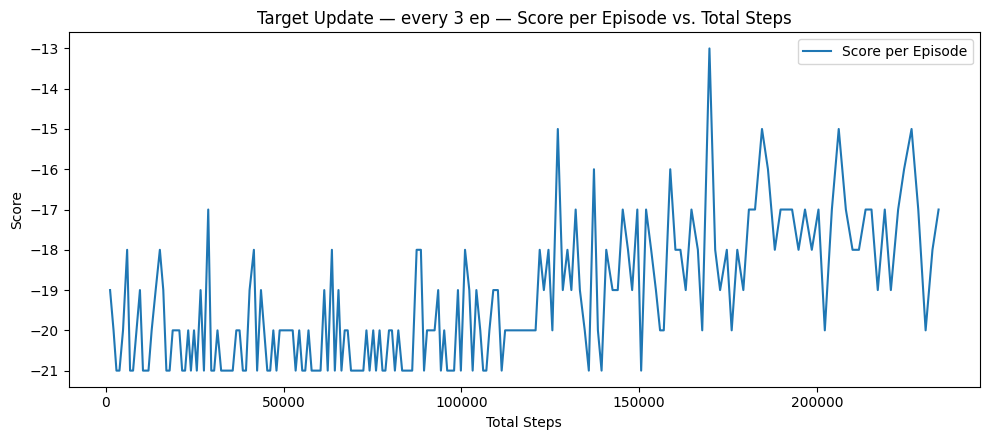

[Saved] results_pong_dqn\exp3_target3_score_vs_steps.png


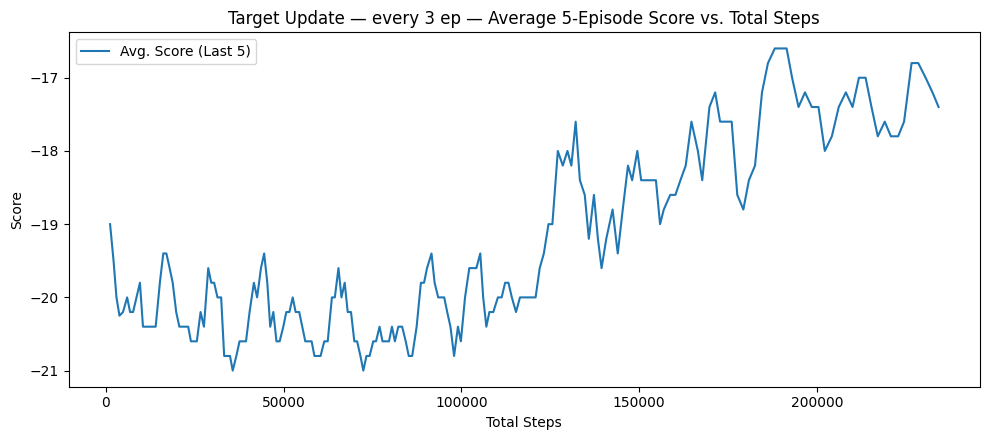

[Saved] results_pong_dqn\exp3_target3_avg5_vs_steps.png
Episodes: 200 | Final Avg(5): -17.40 | Best Score: -13.0 | Total Steps: 234247
===== Done =====



In [22]:
EPISODES = 200  # increase to 200–500 for the report

# Experiment 1 — Default (batch=8, target=10)
exp1 = train_dqn_experiment(episodes=EPISODES, batch_size=8, target_every=10)
results_and_plotting(exp1, "Default (batch=8, target=10)", "exp1_default")

# Experiment 2 — Batch = 16 (target=10)
exp2 = train_dqn_experiment(episodes=EPISODES, batch_size=16, target_every=10)
results_and_plotting(exp2, "Batch Sweep — batch=16", "exp2_batch16")

# Experiment 3 — Target update every 3 episodes (batch=8)
exp3 = train_dqn_experiment(episodes=EPISODES, batch_size=8, target_every=3)
results_and_plotting(exp3, "Target Update — every 3 ep", "exp3_target3")


**1. Default:** batch=8, target=10.     
**2. Batch sweep:** batch=16, target=10.        
**3. Target sweep:** batch=8, target=3.     

Each prints the header and per-episode lines, then triggers “Results & Plotting.”

---

#### **Final Comparison & Recommendation**

Compare the three runs and choose the best combination.


==== COMPARISON — Summary Table ====


,Experiment,Episodes,Final Avg(5),Best Score (max),Mean Score,Total Steps,Median Ep Time (s)
0,"Default: batch=8, target=10",200,-17.4,-13.0,-19.990,210108,37.991851
1,"Batch: batch=16, target=10",200,-18.0,-12.0,-19.195,243599,38.343404
2,"Target: batch=8, target=3",200,-17.4,-13.0,-19.400,234247,37.245279


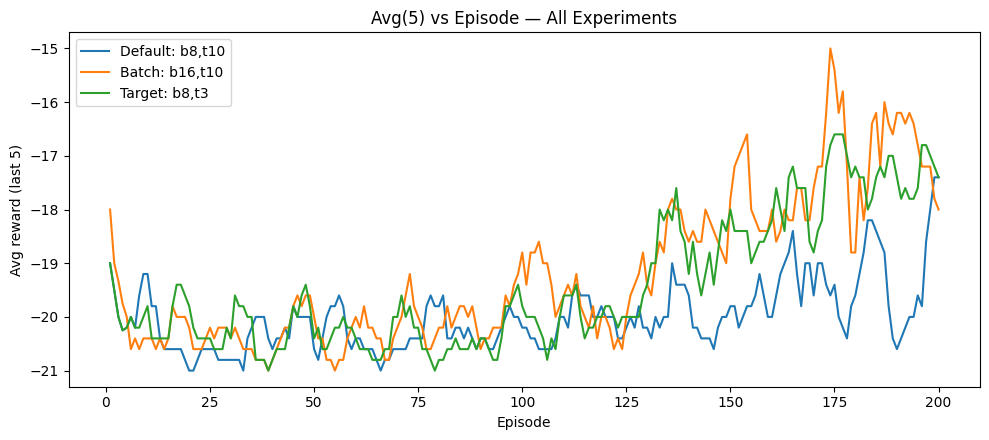

[Saved] results_pong_dqn\comparison_avg5_vs_episode.png

Recommendation (based on Final Avg(5)): **Default: batch=8, target=10**


In [23]:
def compare_experiments(exp1: Dict[str,Any], exp2: Dict[str,Any], exp3: Dict[str,Any]):
    # Build a summary table
    rows = []
    for name, logs in [
        ("Default: batch=8, target=10", exp1),
        ("Batch: batch=16, target=10",   exp2),
        ("Target: batch=8, target=3",    exp3),
    ]:
        df = build_results_df(logs)
        rows.append({
            "Experiment": name,
            "Episodes": len(df),
            "Final Avg(5)": float(df["avg5"].tail(1).values[0]),
            "Best Score (max)": float(df["reward"].max()),
            "Mean Score": float(df["reward"].mean()),
            "Total Steps": int(df["cum_steps"].tail(1).values[0]),
            "Median Ep Time (s)": float(df["ep_time_sec"].median())
        })
    summary = pd.DataFrame(rows)
    print("\n==== COMPARISON — Summary Table ====")
    display(summary)

    # Plot Avg(5) vs Episode for the three runs
    plt.figure(figsize=(10, 4.5))
    for name, logs in [
        ("Default: b8,t10", exp1),
        ("Batch: b16,t10",  exp2),
        ("Target: b8,t3",   exp3),
    ]:
        y = np.array(logs["avg5"])
        x = np.arange(1, len(y)+1)
        plt.plot(x, y, label=name)
    plt.xlabel("Episode"); plt.ylabel("Avg reward (last 5)"); plt.title("Avg(5) vs Episode — All Experiments"); plt.legend()
    cmp_path = os.path.join(OUTDIR, "comparison_avg5_vs_episode.png")
    plt.tight_layout(); plt.savefig(cmp_path, dpi=150); plt.show()
    print(f"[Saved] {cmp_path}")

    # Recommendation based on highest Final Avg(5); tie-breaker = highest Best Score
    best_idx = summary["Final Avg(5)"].idxmax()
    best_row = summary.loc[best_idx]
    rec = best_row["Experiment"]
    print(f"\nRecommendation (based on Final Avg(5)): **{rec}**")
    return summary

# Run comparison after all 3 experiments above
comparison_table = compare_experiments(exp1, exp2, exp3)


Produce a summary table (Episodes, Final Avg(5), Best/Mean Score, Total Steps, Median Episode Time) and an overlay plot of Avg5 vs Episode. Recommend the best setting based on Final Avg(5) (tie-break: Best Score and/or runtime).